In [0]:
!pip install fastai

In [2]:
!mkdir data
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9,tr;q=0.8" "https://storage.googleapis.com/kaggle-competitions-data/kaggle/3004/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1537034736&Signature=NVJbElB1za6gQenpcwDU8ODfLNConhz3w3ajP1dbSWwwbNGisA8KNVUjUq1dgkQbd5GctVEOup5TaJbsHOxjALo3pKflTwmlN%2BU0hxR%2BjqIkEQfS9nVvNx%2BNzHc0DDGPN2xaXX1cUBhwIKenEpWjSD8V9JOME3ADvVqji%2BUG%2B1%2FiY8hywYR%2Ff%2FYnpL8%2FmYV4N5zdkx0OoW7v4SpFxt8vjRmZCEsV8zNK35UJbaP5HJqzJ3RpaQlTaZkA6f8UuH2iYdOtC5lGRUs%2B749OwWvu5xmsoEMSXJHxDP8qP4fwGMXAquguhwwdsoR4EkW6mLfiA6dSIfrU97zO%2FxIOIKzeFA%3D%3D" -O "all.zip" -c
!unzip all.zip -d data/


Redirecting output to ‘wget-log’.
Archive:  all.zip
  inflating: data/train.csv          
  inflating: data/test.csv           
  inflating: data/sample_submission.csv  


In [0]:
!rm all.zip

In [4]:
!ls data


sample_submission.csv  test.csv  train.csv


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [7]:
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


In [0]:
PATH = "content/data/"

In [0]:
train_df = pd.read_csv(f"data/train.csv")
test_df = pd.read_csv(f"data/test.csv")

In [10]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print(train_df.shape, test_df.shape)

(42000, 785) (28000, 784)


In [12]:
val_df = train_df.sample(frac=0.2, random_state=1337)
val_df.shape

(8400, 785)

In [13]:
train_df = train_df.drop(val_df.index)
train_df.shape

(33600, 785)

In [0]:
Y_train = train_df["label"]
Y_valid = val_df["label"]
X_train = train_df.drop("label", axis=1)
X_valid = val_df.drop("label", axis=1)

In [15]:
print(X_train.shape, X_valid.shape)
print(Y_train.shape, Y_valid.shape)

(33600, 784) (8400, 784)
(33600,) (8400,)


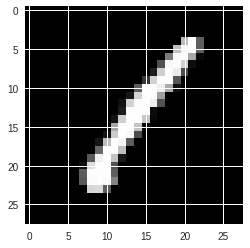

In [16]:
img = X_train.iloc[0,:].values.reshape(28,28)
plt.imshow(img, cmap="gray")

In [0]:
def reshape_img(matrix):
    """
    Reshape an existing 2D pandas.dataframe into 3D-numpy.ndarray
    """
    try:
        return matrix.values.reshape(-1, 28, 28)
    except AttributeError as e:
        print(e)

In [0]:
def add_color_channel(matrix):
    """
    Add missing color channels to previously reshaped image
    """
    matrix = np.stack((matrix, ) *3, axis = -1)
    return matrix

In [0]:
def convert_ndarry(matrix):
    """
    Convert pandas.series into numpy.ndarray
    """
    try:
        return matrix.values.flatten()
    except AttributeError as e:
        print(e)

In [0]:
# reshape data and add color channels
X_train = reshape_img(X_train)
X_train = add_color_channel(X_train)
X_valid = reshape_img(X_valid)
X_valid = add_color_channel(X_valid)
test_df = reshape_img(test_df)
test_df = add_color_channel(test_df)

In [0]:
# convert y_train and y_valid into proper numpy.ndarray
Y_train = convert_ndarry(Y_train)
Y_valid = convert_ndarry(Y_valid)

In [22]:
# run sanity checks
preprocessed_data = [X_train, Y_train, X_valid, Y_valid, test_df]
print([e.shape for e in preprocessed_data])
print([type(e) for e in preprocessed_data])

[(33600, 28, 28, 3), (33600,), (8400, 28, 28, 3), (8400,), (28000, 28, 28, 3)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


In [0]:
# define architecture
arch = resnet50
sz = 28
classes = np.unique(Y_train)

In [24]:
!wget http://files.fast.ai/models/weights.tgz


Redirecting output to ‘wget-log.1’.


In [53]:
!ls

content  data  sample_data  weights.tgz  wget-log  wget-log.1


In [60]:
!tar -xvzf ../content/weights.tgz -C /usr/local/lib/python3.6/dist-packages/fastai


weights/
weights/wrn_50_2f.pth
weights/resnext_101_32x4d.pth
weights/resnext_101_64x4d.pth
weights/inceptionresnetv2-d579a627.pth
weights/inceptionv4-97ef9c30.pth
weights/resnext_50_32x4d.pth


In [0]:
data = ImageClassifierData.from_arrays(path=PATH, 
                                       trn=(X_train, Y_train),
                                       val=(X_valid, Y_valid),
                                       classes=Y_train,
                                       test=test_df,
                                       tfms=tfms_from_model(arch, sz))

In [26]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 77151201.27it/s]


100%|██████████| 438/438 [00:24<00:00, 18.01it/s]


In [27]:
# find optimal learning rate
lrf = learn.lr_find()

 83%|████████▎ | 436/525 [00:11<00:02, 38.61it/s, loss=3.43]

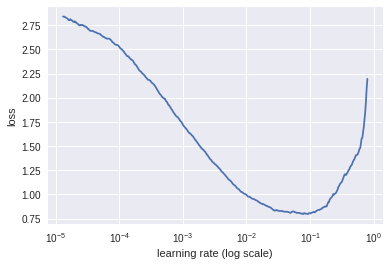

In [28]:
learn.sched.plot()

In [29]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.42742    0.416245   0.904643  
    1      0.333931   0.281213   0.926429  
CPU times: user 24 s, sys: 16.7 s, total: 40.8 s
Wall time: 30.2 s


[array([0.28121]), 0.9264285714285714]

In [0]:
learn.precompute=False
learn.unfreeze()

In [0]:
lr = np.array([0.001, 0.00316, 0.01])

In [0]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.000548   0.029351   0.993333  
    1      0.01624    0.032748   0.993095  
    2      0.003204   0.030629   0.992143  
    3      0.022412   0.039935   0.989643  
    4      0.010658   0.029772   0.991905  
 63%|██████▎   | 332/525 [00:48<00:28,  6.87it/s, loss=0.00411]

In [0]:
# save full model
#learn.save("28_all")

In [0]:
# get accuracy for validation set
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

In [0]:
# predict on test set
%time log_preds_test, y_test = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test), 0)
probs_test.shape

# Submission

In [0]:
# create dataframe from probabilities
df = pd.DataFrame(probs_test)

In [0]:
# increase index by 1 to obtain proper ImageIDs
df.index += 1

In [0]:
# create new colum containing label with highest probability for each digit
df = df.assign(Label = df.values.argmax(axis=1))

In [0]:
# replicate index as dedicated ImageID column necessary for submission
df = df.assign(ImageId = df.index.values)

In [0]:
# drop individual probabilites
df = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)

In [0]:
# reorder columns for submission
df = df[["ImageId", "Label"]]

In [0]:
# run sanity checks
df.head()

In [0]:
# ...
df.tail()

In [0]:
# ...
df.shape

In [0]:
# write dataframe to CSV
df.to_csv(f"sub_{comp_name}_{arch.__name__}.csv", index=False)

In [0]:
def clean_up():
    """
    Delete all temporary directories and symlinks in the current directory
    """
    try:
        shutil.rmtree("models")
        shutil.rmtree("tmp")
        os.unlink("test.csv")
        os.unlink("train.csv")
    except FileNotFoundError as e:
        print(e)

In [0]:
clean_up()